In [1]:
!pip install torch -q
!git clone https://github.com/IDEA-Research/GroundingDINO 
!pip install -e GroundingDINO -q

fatal: destination path 'GroundingDINO' already exists and is not an empty directory.


In [2]:
!pip install datasets -q

In [3]:
import os
import sys

# Add 'GroundingDINO' to the PYTHONPATH
os.environ['PYTHONPATH'] = f"GroundingDINO:{os.environ.get('PYTHONPATH', '')}"
sys.path.append('GroundingDINO')

In [4]:
import torch
import sys
import os
import supervision as sv
import torchvision.transforms as T
from PIL import Image
import numpy as np
import groundingdino
from groundingdino.util.inference import load_model, load_image, predict, annotate
from datasets import load_dataset
from tqdm import tqdm
import yaml
import json
import warnings
import requests
from torchvision import transforms
from datasets import DatasetDict

In [5]:
if torch.cuda.is_available():
    print("GPU will be used.")
    device = torch.device("cuda")
else:
    print("CUDA is not available. CPU will be used.")
    device = torch.device("cpu")

!ldconfig -p | grep libGL.so.1

GPU will be used.
	libGL.so.1 (libc6,x86-64) => /usr/lib/x86_64-linux-gnu/libGL.so.1


In [6]:
warnings.filterwarnings("ignore", category=UserWarning)
os.environ["TOKENIZERS_PARALLELISM"] = "false"
sys.path.append('/kaggle/working/GroundingDINO')

In [7]:
!wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth
model = load_model('GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py', 'groundingdino_swint_ogc.pth')

final text_encoder_type: bert-base-uncased


In [8]:
def run_dino(dino, image, text_prompt='food', box_threshold=0.4, text_threshold=0.1):
    boxes, logits, phrases = predict(
        model = dino, 
        image = image, 
        caption = text_prompt, 
        box_threshold = box_threshold, 
        text_threshold = text_threshold
    )
    return boxes, logits, phrases

In [9]:
from PIL import Image
import numpy as np
import torchvision.transforms as T

def preprocess_image(image):
    """
    Preprocess the image for GroundingDINO.
    - Handles PIL Image, PngImageFile, or image paths.
    - Converts the image to RGB and resizes it to 640x640.
    - Normalizes and returns the image tensor and the original image.
    """
    if isinstance(image, str):  # If the input is a file path
        image = Image.open(image).convert("RGB")
    elif isinstance(image, np.ndarray):  # If the input is a NumPy array
        image = Image.fromarray(image).convert("RGB")
    elif not isinstance(image, Image.Image):  # For unexpected types
        raise ValueError("Unsupported image type. Must be file path, NumPy array, or PIL Image.")

    transform = T.Compose([
        T.Resize((640, 640)),  
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    image_tensor = transform(image)
    image_np = np.array(image)

    return image_tensor, image_np

In [10]:

url = "https://static01.nyt.com/images/2020/02/02/arts/02met1/02met1-superJumbo.jpg"
response = requests.get(url)

with open("painting.jpg", "wb") as file:
    file.write(response.content)

print("Image saved as painting.jpg")

Image saved as painting.jpg


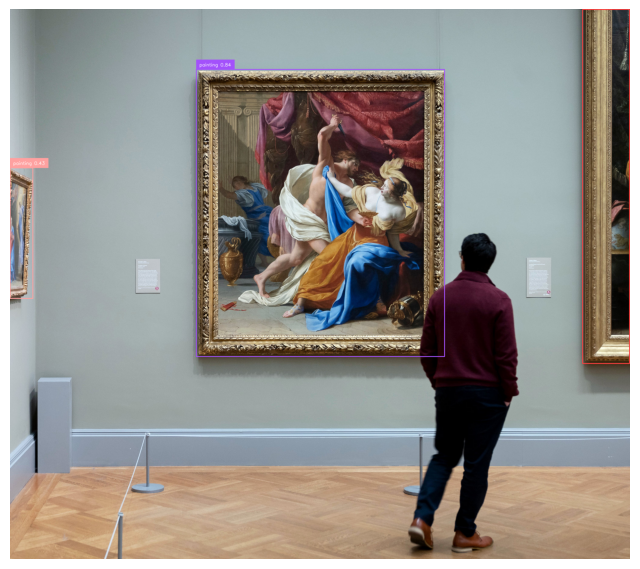

In [11]:
image_path = "painting.jpg"
image_tensor, original_image = preprocess_image(image_path)
text_prompt = "painting"  # Replace with your desired object
boxes, logits, phrases = run_dino(model, image_tensor, text_prompt)
annotated_frame = annotate(image_source=original_image, boxes=boxes, logits=logits, phrases=phrases)
sv.plot_image(annotated_frame, (8, 8))

In [12]:
dataset = load_dataset('anand94ap/orangerie_museum_art_piece')
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 636
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 106
    })
})

In [13]:
import os
from tqdm import tqdm

def fetch_labels(dino, data, data_dir):
    data = data.train_test_split(train_size=len(data)-1)['train']

    image_dir = f'{data_dir}/images'
    label_dir = f'{data_dir}/labels'
    os.makedirs(image_dir, exist_ok=True)
    os.makedirs(label_dir, exist_ok=True)
    
    for i, d in enumerate(tqdm(data, desc="Processing data")):
        image_path = f'{image_dir}/{i:06d}.png'
        label_path = f'{label_dir}/{i:06d}.txt'
        
        # Resize and save image
        image = d['image']
        image.save(image_path)
        
        # Load image and run the model
        image_source, processed_image = load_image(image_path)
        boxes, logits, phrases = run_dino(dino, processed_image)

        # Get painting label ID
        painting_id = str(d['label'])
        
        if boxes is not None and len(boxes) > 0:
            # Construct YOLO label lines: <class_id> <center_x> <center_y> <width> <height>
            label = [
                f"{painting_id} " + " ".join(map(str, b))
                for b in boxes.tolist()
            ]
            label = "\n".join(label)
        else:
            # Handle cases where no boxes are detected
            label = ""

        # Write labels to the file
        with open(label_path, 'w') as f:
            f.write(label)

In [14]:
print(set(dataset["train"]["label"]))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90}


In [15]:
fetch_labels(model, dataset['train'], 'data/train')
fetch_labels(model, dataset['validation'], 'data/valid')

Processing data: 100%|██████████| 105/105 [00:23<00:00,  4.40it/s]


In [16]:
import os

def validate_labels(label_dir, num_classes):
    errors = []
    for label_file in os.listdir(label_dir):
        if not label_file.endswith(".txt"):
            continue
        with open(os.path.join(label_dir, label_file), "r") as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) != 5:
                    errors.append(f"Invalid line in {label_file}: {line.strip()}")
                else:
                    class_id = int(parts[0])
                    if class_id < 0 or class_id >= num_classes:
                        errors.append(f"Invalid class ID {class_id} in {label_file}")
    return errors

# Validate
label_dir = "/data/data/train/labels"
num_classes = 91  # Update with your dataset's number of classes
errors = validate_labels(label_dir, num_classes)

if errors:
    print("Label errors:")
    for error in errors:
        print(error)
else:
    print("All labels are valid.")

All labels are valid.


In [17]:
import os

def check_images_labels(image_dir, label_dir):
    missing_images = []
    for label_file in os.listdir(label_dir):
        if not label_file.endswith(".txt"):
            continue
        # Match image file name with label file name
        image_file = os.path.join(image_dir, label_file.replace(".txt", ".png"))
        if not os.path.exists(image_file):
            missing_images.append(image_file)
    return missing_images

image_dir = "/data/data/train/images"
label_dir = "/data/data/train/labels"

missing_images = check_images_labels(image_dir, label_dir)

if missing_images:
    print("Missing images:")
    for img in missing_images:
        print(img)
else:
    print("All images are present.")

All images are present.


In [18]:
import json

json_file = "label_mapping.json"

with open(json_file, "r", encoding="utf-8") as file:
    data = json.load(file)

class_names = list(data["id2label"].values())

In [25]:
import yaml

# Configuration
config = {
    'train': '/data/data/train/images',
    'val': '/data/data/valid/images',
    'nc': 91,
    'names': class_names
}

# Write to YAML file
with open('/data/data/data.yaml', 'w') as f:
    yaml.dump(config, f, default_flow_style=True)  # Use default_flow_style=True for inline lists

In [26]:
def update_datasets_dir(file_path: str, new_dir: str):
    """
    Updates the datasets_dir field in a JSON file.

    :param file_path: Path to the JSON file.
    :param new_dir: New value for the datasets_dir field.
    """
    try:
        with open(file_path, 'r') as f:
            data = json.load(f)
        data['datasets_dir'] = new_dir
        with open(file_path, 'w') as f:
            json.dump(data, f, indent=2)
        print(f"Updated datasets_dir to: {new_dir}")
    except FileNotFoundError:
        print(f"Error: The file {file_path} does not exist.")
    except json.JSONDecodeError:
        print("Error: Failed to decode JSON. Please check the file format.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

In [27]:
!cat /home/user/.config/Ultralytics/settings.json

{
  "settings_version": "0.0.6",
  "datasets_dir": "/data/data",
  "weights_dir": "weights",
  "runs_dir": "runs",
  "uuid": "fe4725d448b3d888f863cd94ae17b674e5c3a759f21477e7861d08785c978158",
  "sync": true,
  "api_key": "",
  "openai_api_key": "",
  "clearml": true,
  "comet": true,
  "dvc": true,
  "hub": true,
  "mlflow": true,
  "neptune": true,
  "raytune": true,
  "tensorboard": true,
  "wandb": false,
  "vscode_msg": true
}

In [22]:
os.chdir("/data/")

In [23]:
!pip uninstall ultralytics -yq
!pip install ultralytics -q
from ultralytics import YOLO

In [28]:
import os
from ultralytics.data.utils import DATASETS_DIR
os.chdir("/data/")

new_dataset_dir = '/data/data'  # Set to your actual dataset directory
os.environ['DATASETS_DIR'] = new_dataset_dir
update_datasets_dir('/home/user/.config/Ultralytics/settings.json', new_dataset_dir)

print("Updated Dataset Directory:", os.environ['DATASETS_DIR'])

model = YOLO("yolo11n.pt")
model.train(data='/data/data/data.yaml', epochs=150, project='working/runs', name='train')

Updated datasets_dir to: /data/data
Updated Dataset Directory: /data/data
Ultralytics 8.3.36 🚀 Python-3.9.5 torch-2.5.1+cu124 CUDA:0 (NVIDIA L40S, 45386MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/data/data/data.yaml, epochs=150, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=working/runs, name=train36, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False

train: Scanning /data/data/train/labels... 635 images, 48 backgrounds, 0 corrupt: 100%|██████████| 635/635 [00:00<00:00, 1373.61it/s]

train: New cache created: /data/data/train/labels.cache



val: Scanning /data/data/valid/labels... 105 images, 6 backgrounds, 0 corrupt: 100%|██████████| 105/105 [00:00<00:00, 1034.95it/s]


val: New cache created: /data/data/valid/labels.cache
Plotting labels to working/runs/train36/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000105, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to working/runs/train36
Starting training for 150 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/150      2.77G     0.7627      4.992      1.242         30        640: 100%|██████████| 40/40 [00:03<00:00, 10.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 13.39it/s]

                   all        105        127          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/150      2.68G     0.5817      4.905       1.14         29        640: 100%|██████████| 40/40 [00:02<00:00, 14.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 21.13it/s]

                   all        105        127          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/150      2.74G     0.5471      4.808      1.094         18        640: 100%|██████████| 40/40 [00:02<00:00, 14.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 14.78it/s]

                   all        105        127     0.0112      0.222     0.0399      0.036



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/150      2.64G     0.5347      4.732       1.07         19        640: 100%|██████████| 40/40 [00:02<00:00, 14.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 14.35it/s]

                   all        105        127     0.0108      0.329     0.0733     0.0648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/150      2.66G      0.508      4.582      1.065         24        640: 100%|██████████| 40/40 [00:02<00:00, 14.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 14.07it/s]

                   all        105        127      0.734      0.088       0.11      0.104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/150      2.68G     0.5051      4.454      1.045         37        640: 100%|██████████| 40/40 [00:02<00:00, 14.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 14.10it/s]

                   all        105        127      0.812      0.113      0.161      0.155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/150      2.64G      0.501      4.351      1.046         23        640: 100%|██████████| 40/40 [00:02<00:00, 14.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 13.87it/s]

                   all        105        127      0.856      0.118      0.201      0.185



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/150      2.64G     0.4942      4.232      1.035         33        640: 100%|██████████| 40/40 [00:02<00:00, 14.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 14.10it/s]

                   all        105        127       0.66      0.144        0.2      0.192



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/150      2.64G     0.5043      4.105      1.049         15        640: 100%|██████████| 40/40 [00:02<00:00, 14.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 14.48it/s]

                   all        105        127      0.869      0.139      0.198      0.188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/150      2.64G     0.4963      3.969      1.046         30        640: 100%|██████████| 40/40 [00:02<00:00, 14.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 14.00it/s]

                   all        105        127      0.634      0.188      0.264      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/150      2.64G      0.459      3.725      1.028         25        640: 100%|██████████| 40/40 [00:02<00:00, 14.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 14.32it/s]

                   all        105        127      0.606      0.221      0.297      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/150      2.64G     0.4863      3.617      1.036         30        640: 100%|██████████| 40/40 [00:02<00:00, 14.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 13.66it/s]

                   all        105        127      0.709      0.208      0.338      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/150      2.64G     0.4958      3.525      1.045         32        640: 100%|██████████| 40/40 [00:02<00:00, 14.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 13.90it/s]

                   all        105        127       0.47      0.362      0.376      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/150      2.64G       0.47      3.303      1.025         21        640: 100%|██████████| 40/40 [00:02<00:00, 15.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.99it/s]

                   all        105        127      0.471      0.399      0.418      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/150      2.64G     0.4981      3.213      1.042         27        640: 100%|██████████| 40/40 [00:02<00:00, 14.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 14.18it/s]

                   all        105        127      0.485      0.489      0.472      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/150      2.64G     0.4682      3.027      1.028         25        640: 100%|██████████| 40/40 [00:02<00:00, 14.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 13.50it/s]

                   all        105        127      0.747       0.37      0.514       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/150      2.64G     0.4693      2.919      1.026         43        640: 100%|██████████| 40/40 [00:02<00:00, 14.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 13.75it/s]

                   all        105        127      0.501      0.526       0.58      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/150      2.64G      0.453      2.767      1.021         30        640: 100%|██████████| 40/40 [00:02<00:00, 14.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 13.42it/s]

                   all        105        127      0.765      0.433      0.605      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/150      2.64G     0.4455      2.657      1.017         22        640: 100%|██████████| 40/40 [00:02<00:00, 14.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 13.73it/s]

                   all        105        127      0.732      0.515      0.669      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/150      2.64G     0.4502      2.617      1.005         23        640: 100%|██████████| 40/40 [00:02<00:00, 14.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 13.82it/s]

                   all        105        127      0.698      0.562       0.71      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/150      2.64G     0.4727      2.493      1.031         28        640: 100%|██████████| 40/40 [00:02<00:00, 14.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 13.88it/s]

                   all        105        127      0.577      0.616      0.695      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/150      2.64G     0.4553      2.434      1.032         31        640: 100%|██████████| 40/40 [00:02<00:00, 14.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 13.73it/s]

                   all        105        127      0.545      0.747      0.755      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/150      2.64G     0.4492      2.379      1.016         30        640: 100%|██████████| 40/40 [00:02<00:00, 14.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 13.72it/s]

                   all        105        127      0.656      0.655      0.771      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/150      2.64G     0.4272      2.272      1.007         23        640: 100%|██████████| 40/40 [00:02<00:00, 14.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 13.81it/s]

                   all        105        127      0.546      0.674       0.77      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/150      2.64G     0.4213      2.215     0.9998         36        640: 100%|██████████| 40/40 [00:02<00:00, 14.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 13.89it/s]

                   all        105        127      0.604      0.701      0.767      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/150      2.64G     0.4166      2.196      1.002         26        640: 100%|██████████| 40/40 [00:02<00:00, 14.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 14.10it/s]

                   all        105        127      0.749      0.623      0.794       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/150      2.64G     0.4073      2.059     0.9837         35        640: 100%|██████████| 40/40 [00:02<00:00, 13.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 13.94it/s]

                   all        105        127       0.78      0.641      0.807      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/150      2.64G     0.4171      2.054     0.9996         27        640: 100%|██████████| 40/40 [00:02<00:00, 14.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 13.66it/s]

                   all        105        127      0.628      0.684      0.765      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/150      2.64G     0.4174      1.974      1.004         39        640: 100%|██████████| 40/40 [00:02<00:00, 14.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 13.79it/s]

                   all        105        127      0.685       0.68      0.781      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/150      2.64G     0.4045      1.888     0.9869         33        640: 100%|██████████| 40/40 [00:02<00:00, 14.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 14.08it/s]

                   all        105        127      0.694       0.75      0.829      0.804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/150      2.74G     0.4064      1.864     0.9927         30        640: 100%|██████████| 40/40 [00:02<00:00, 14.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 13.64it/s]

                   all        105        127       0.57      0.767      0.796      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/150      2.64G     0.3948      1.816     0.9803         25        640: 100%|██████████| 40/40 [00:02<00:00, 14.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 13.54it/s]

                   all        105        127      0.712      0.691      0.799      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/150      2.64G     0.3861      1.775     0.9869         22        640: 100%|██████████| 40/40 [00:02<00:00, 14.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 13.87it/s]

                   all        105        127      0.763      0.696       0.84      0.804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/150      2.64G     0.3651      1.681     0.9637         27        640: 100%|██████████| 40/40 [00:02<00:00, 14.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 13.87it/s]

                   all        105        127      0.675      0.794       0.85      0.821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/150      2.64G     0.3686      1.627     0.9662         31        640: 100%|██████████| 40/40 [00:02<00:00, 14.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 14.10it/s]

                   all        105        127      0.731      0.724      0.843      0.816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/150      2.64G     0.3846      1.667     0.9776         16        640: 100%|██████████| 40/40 [00:02<00:00, 14.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 13.80it/s]

                   all        105        127      0.826      0.707       0.83      0.804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/150      2.64G     0.3695      1.635     0.9646         26        640: 100%|██████████| 40/40 [00:02<00:00, 14.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 14.13it/s]

                   all        105        127      0.828      0.717      0.843      0.821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/150      2.64G     0.3793      1.587     0.9712         21        640: 100%|██████████| 40/40 [00:02<00:00, 14.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 13.87it/s]

                   all        105        127      0.727      0.743      0.849      0.823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/150      2.64G     0.3779      1.537     0.9742         34        640: 100%|██████████| 40/40 [00:02<00:00, 14.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 13.75it/s]

                   all        105        127      0.789      0.741      0.854      0.832



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/150      2.64G     0.3757      1.533     0.9731         22        640: 100%|██████████| 40/40 [00:02<00:00, 14.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 13.97it/s]

                   all        105        127      0.749      0.783      0.883      0.849



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/150      2.65G     0.3597       1.49     0.9678         31        640: 100%|██████████| 40/40 [00:02<00:00, 15.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 14.23it/s]

                   all        105        127       0.75      0.759      0.856      0.828



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/150      2.68G      0.361      1.503     0.9609         30        640: 100%|██████████| 40/40 [00:02<00:00, 14.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 13.98it/s]

                   all        105        127      0.788      0.765      0.858      0.837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/150      2.64G     0.3539       1.43     0.9648         21        640: 100%|██████████| 40/40 [00:02<00:00, 14.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 13.77it/s]

                   all        105        127      0.815      0.734      0.876      0.841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/150      2.64G     0.3531      1.434     0.9594         23        640: 100%|██████████| 40/40 [00:02<00:00, 14.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 14.07it/s]

                   all        105        127      0.836      0.732      0.865       0.84



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/150      2.64G      0.346      1.381     0.9593         24        640: 100%|██████████| 40/40 [00:02<00:00, 14.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 13.92it/s]

                   all        105        127        0.8      0.757      0.879      0.856



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/150      2.64G     0.3485      1.368     0.9536         32        640: 100%|██████████| 40/40 [00:02<00:00, 15.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 13.81it/s]

                   all        105        127      0.813      0.748      0.871      0.847



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/150      2.64G     0.3536      1.393      0.963         26        640: 100%|██████████| 40/40 [00:02<00:00, 15.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 14.19it/s]

                   all        105        127      0.778      0.771      0.865      0.839



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/150      2.64G     0.3393      1.336     0.9445         23        640: 100%|██████████| 40/40 [00:02<00:00, 14.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 13.76it/s]

                   all        105        127      0.748      0.771       0.86      0.838



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/150      2.64G     0.3453      1.322     0.9531         31        640: 100%|██████████| 40/40 [00:02<00:00, 14.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 14.14it/s]

                   all        105        127      0.855       0.75      0.897      0.867



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/150      2.64G     0.3451      1.325     0.9579         34        640: 100%|██████████| 40/40 [00:02<00:00, 14.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 13.68it/s]

                   all        105        127      0.797      0.822      0.902      0.874



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/150      2.64G     0.3479       1.32     0.9419         36        640: 100%|██████████| 40/40 [00:02<00:00, 14.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 14.14it/s]

                   all        105        127      0.822      0.771      0.898      0.876



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/150      2.64G      0.334      1.269     0.9494         33        640: 100%|██████████| 40/40 [00:02<00:00, 14.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 13.85it/s]

                   all        105        127      0.737      0.795      0.872       0.85



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/150      2.64G     0.3356      1.225     0.9535         33        640: 100%|██████████| 40/40 [00:02<00:00, 14.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 13.83it/s]

                   all        105        127       0.78      0.757      0.886      0.854



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/150      2.64G     0.3401      1.256     0.9474         16        640: 100%|██████████| 40/40 [00:02<00:00, 14.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 13.75it/s]

                   all        105        127      0.748      0.835      0.914      0.884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/150      2.64G     0.3285      1.222      0.948         21        640: 100%|██████████| 40/40 [00:02<00:00, 14.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 13.99it/s]

                   all        105        127      0.844      0.786      0.904      0.874



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/150      2.64G     0.3392      1.251     0.9628         26        640: 100%|██████████| 40/40 [00:02<00:00, 14.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 13.96it/s]

                   all        105        127      0.788      0.813      0.914      0.882



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/150      2.64G     0.3189      1.211     0.9531         34        640: 100%|██████████| 40/40 [00:02<00:00, 14.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 13.98it/s]

                   all        105        127      0.818      0.787      0.892      0.865



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/150      2.64G     0.3197      1.164      0.942         32        640: 100%|██████████| 40/40 [00:02<00:00, 14.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 14.08it/s]

                   all        105        127      0.756      0.793      0.885      0.859



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/150      2.64G     0.3256      1.167     0.9463         25        640: 100%|██████████| 40/40 [00:02<00:00, 14.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 13.92it/s]

                   all        105        127      0.826      0.792      0.888      0.864



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/150      2.66G     0.3165      1.131     0.9408         24        640: 100%|██████████| 40/40 [00:02<00:00, 14.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 13.89it/s]

                   all        105        127       0.79      0.799      0.887       0.86



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/150      2.69G     0.3117      1.128      0.931         24        640: 100%|██████████| 40/40 [00:02<00:00, 14.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 13.83it/s]

                   all        105        127      0.786      0.813      0.905      0.883



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/150      2.64G     0.3236       1.14     0.9428         35        640: 100%|██████████| 40/40 [00:02<00:00, 14.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 13.74it/s]

                   all        105        127      0.823      0.798      0.882      0.855



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/150      2.64G     0.3236      1.132     0.9412         32        640: 100%|██████████| 40/40 [00:02<00:00, 14.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 13.78it/s]

                   all        105        127      0.811      0.766       0.88      0.852



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/150      2.64G     0.3122      1.112     0.9276         25        640: 100%|██████████| 40/40 [00:02<00:00, 14.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 14.12it/s]

                   all        105        127      0.852       0.74      0.888       0.86



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/150      2.64G     0.3188      1.119     0.9512         26        640: 100%|██████████| 40/40 [00:02<00:00, 14.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 14.28it/s]

                   all        105        127      0.822      0.773       0.88      0.851



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/150      2.64G     0.3177      1.118     0.9508         36        640: 100%|██████████| 40/40 [00:02<00:00, 14.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 13.90it/s]

                   all        105        127      0.815      0.806      0.915      0.891



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/150      2.64G     0.3157      1.096     0.9371         32        640: 100%|██████████| 40/40 [00:02<00:00, 14.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 13.74it/s]

                   all        105        127      0.809      0.791      0.915       0.89



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/150      2.64G      0.305      1.081      0.934         24        640: 100%|██████████| 40/40 [00:02<00:00, 14.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 13.85it/s]

                   all        105        127      0.769      0.807      0.907      0.884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/150      2.66G     0.3175      1.102     0.9418         29        640: 100%|██████████| 40/40 [00:02<00:00, 14.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 13.70it/s]

                   all        105        127      0.839      0.811      0.918      0.894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/150      2.69G     0.3222      1.092     0.9364         23        640: 100%|██████████| 40/40 [00:02<00:00, 14.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 13.92it/s]

                   all        105        127      0.742      0.834      0.901      0.874



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/150      2.64G     0.2996      1.051     0.9158         32        640: 100%|██████████| 40/40 [00:02<00:00, 14.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 14.22it/s]

                   all        105        127      0.826      0.775      0.914      0.894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/150      2.64G     0.3142      1.083     0.9377         20        640: 100%|██████████| 40/40 [00:02<00:00, 14.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 13.35it/s]

                   all        105        127      0.799      0.808       0.92      0.897



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/150      2.64G     0.3106      1.059     0.9339         34        640: 100%|██████████| 40/40 [00:02<00:00, 14.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 14.08it/s]

                   all        105        127      0.759      0.841       0.91      0.878



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/150      2.64G     0.3053      1.023     0.9288         22        640: 100%|██████████| 40/40 [00:02<00:00, 14.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 13.97it/s]

                   all        105        127      0.761      0.842      0.921      0.892



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/150      2.64G     0.2986       1.02     0.9241         18        640: 100%|██████████| 40/40 [00:02<00:00, 14.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.96it/s]

                   all        105        127      0.801      0.822      0.908      0.884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/150      2.64G     0.3149      1.023     0.9371         34        640: 100%|██████████| 40/40 [00:02<00:00, 14.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.96it/s]

                   all        105        127      0.808      0.812      0.895      0.868



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/150      2.64G     0.3046       1.03     0.9217         21        640: 100%|██████████| 40/40 [00:02<00:00, 14.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 13.48it/s]

                   all        105        127      0.857      0.797      0.911      0.883



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/150      2.64G     0.2891     0.9786     0.9273         27        640: 100%|██████████| 40/40 [00:02<00:00, 14.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 13.49it/s]

                   all        105        127      0.869      0.765      0.911      0.883



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/150      2.64G     0.2867     0.9714     0.9252         33        640: 100%|██████████| 40/40 [00:02<00:00, 14.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 13.55it/s]

                   all        105        127      0.843      0.805      0.918      0.898



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/150      2.64G      0.279      0.974     0.9181         29        640: 100%|██████████| 40/40 [00:02<00:00, 14.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 13.70it/s]

                   all        105        127      0.799      0.836      0.923      0.901



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/150      2.64G     0.2885     0.9766     0.9273         34        640: 100%|██████████| 40/40 [00:02<00:00, 14.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 13.66it/s]

                   all        105        127      0.777      0.806      0.915      0.893



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/150      2.64G     0.2903     0.9793     0.9321         22        640: 100%|██████████| 40/40 [00:02<00:00, 14.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 13.88it/s]

                   all        105        127      0.834      0.764      0.913      0.889



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/150      2.64G     0.2906       1.01     0.9323         36        640: 100%|██████████| 40/40 [00:02<00:00, 14.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 13.79it/s]

                   all        105        127      0.753      0.833      0.895      0.871



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/150      2.64G      0.293     0.9704      0.918         28        640: 100%|██████████| 40/40 [00:02<00:00, 14.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 14.14it/s]

                   all        105        127      0.742      0.835      0.897       0.87



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/150      2.64G      0.293     0.9524     0.9223         25        640: 100%|██████████| 40/40 [00:02<00:00, 14.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 13.86it/s]

                   all        105        127      0.798      0.829      0.913      0.889



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/150      2.64G       0.28     0.9252     0.9139         32        640: 100%|██████████| 40/40 [00:02<00:00, 14.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 14.19it/s]

                   all        105        127      0.797      0.821      0.901      0.879



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/150      2.64G      0.273     0.9369     0.9251         27        640: 100%|██████████| 40/40 [00:02<00:00, 14.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 13.75it/s]

                   all        105        127      0.844      0.806      0.909      0.886



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/150      2.64G     0.2741     0.9433     0.9179         29        640: 100%|██████████| 40/40 [00:02<00:00, 14.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 13.99it/s]

                   all        105        127      0.762      0.818      0.907      0.884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/150      2.64G     0.3043     0.9672     0.9363         24        640: 100%|██████████| 40/40 [00:02<00:00, 14.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 14.09it/s]

                   all        105        127      0.859      0.756      0.888      0.864



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/150      2.74G     0.2801     0.9298     0.9159         28        640: 100%|██████████| 40/40 [00:02<00:00, 14.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 13.72it/s]

                   all        105        127      0.759      0.788      0.873      0.854



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/150      2.64G     0.2906     0.9227     0.9271         30        640: 100%|██████████| 40/40 [00:02<00:00, 14.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 13.85it/s]

                   all        105        127      0.828      0.805      0.894      0.867



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/150      2.64G     0.2872     0.8989      0.921         22        640: 100%|██████████| 40/40 [00:02<00:00, 14.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 13.82it/s]

                   all        105        127      0.787      0.805      0.909      0.886



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/150      2.64G     0.2713     0.9121     0.9159         26        640: 100%|██████████| 40/40 [00:02<00:00, 14.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 14.08it/s]

                   all        105        127      0.838      0.797      0.901      0.876



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/150      2.64G     0.2867     0.9252     0.9269         21        640: 100%|██████████| 40/40 [00:02<00:00, 14.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 13.11it/s]

                   all        105        127       0.79      0.817      0.924      0.903



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/150      2.64G     0.2885     0.9203     0.9255         33        640: 100%|██████████| 40/40 [00:02<00:00, 15.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 14.23it/s]

                   all        105        127      0.848      0.778      0.908      0.886



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/150      2.64G     0.2827     0.9021     0.9175         25        640: 100%|██████████| 40/40 [00:02<00:00, 14.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 13.59it/s]

                   all        105        127      0.827       0.79      0.906      0.883



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/150      2.64G     0.2714     0.8779     0.9149         26        640: 100%|██████████| 40/40 [00:02<00:00, 14.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 13.69it/s]

                   all        105        127      0.828       0.78      0.905      0.882



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/150      2.64G     0.2683     0.8746     0.9104         24        640: 100%|██████████| 40/40 [00:02<00:00, 14.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 13.65it/s]

                   all        105        127      0.854      0.778      0.921      0.898



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/150      2.64G     0.2751     0.9018     0.9218         22        640: 100%|██████████| 40/40 [00:02<00:00, 14.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 13.83it/s]

                   all        105        127      0.862      0.795      0.898      0.878



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/150      2.64G     0.2674     0.8925     0.9105         18        640: 100%|██████████| 40/40 [00:02<00:00, 14.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 14.25it/s]

                   all        105        127      0.881      0.773      0.908      0.887



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/150      2.64G     0.2813      0.898     0.9191         21        640: 100%|██████████| 40/40 [00:02<00:00, 14.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 13.70it/s]

                   all        105        127      0.848       0.81      0.913      0.891



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/150      2.64G     0.2693     0.8742     0.9101         22        640: 100%|██████████| 40/40 [00:02<00:00, 14.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 14.20it/s]

                   all        105        127      0.778      0.819        0.9      0.875



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/150      2.64G     0.2593     0.8783     0.9121         32        640: 100%|██████████| 40/40 [00:02<00:00, 14.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 14.06it/s]

                   all        105        127      0.889       0.76      0.906      0.884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/150      2.64G     0.2691     0.8627     0.9211         39        640: 100%|██████████| 40/40 [00:02<00:00, 14.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 13.74it/s]

                   all        105        127      0.882      0.793      0.919      0.895



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/150      2.64G     0.2691     0.8937     0.9039         23        640: 100%|██████████| 40/40 [00:02<00:00, 14.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 14.21it/s]

                   all        105        127      0.855      0.797      0.935      0.915



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/150      2.64G     0.2694     0.8646     0.9142         35        640: 100%|██████████| 40/40 [00:02<00:00, 14.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 14.48it/s]

                   all        105        127      0.872      0.781      0.919      0.899



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/150      2.65G     0.2681     0.8523     0.9137         28        640: 100%|██████████| 40/40 [00:02<00:00, 14.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.80it/s]

                   all        105        127      0.883      0.776      0.909      0.889



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/150      2.68G     0.2659     0.8487     0.9082         22        640: 100%|██████████| 40/40 [00:02<00:00, 14.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 14.21it/s]

                   all        105        127      0.814      0.816      0.908      0.886



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/150      2.66G     0.2556     0.8454     0.9034         27        640: 100%|██████████| 40/40 [00:02<00:00, 14.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 14.17it/s]

                   all        105        127      0.828      0.797      0.905      0.884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/150      2.68G     0.2618     0.8538      0.914         23        640: 100%|██████████| 40/40 [00:02<00:00, 14.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 13.76it/s]

                   all        105        127      0.896       0.75      0.914      0.895



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/150      2.64G     0.2681     0.8416     0.9104         25        640: 100%|██████████| 40/40 [00:02<00:00, 14.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 13.66it/s]

                   all        105        127      0.889      0.757      0.919      0.897



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/150      2.64G      0.255     0.8433      0.908         27        640: 100%|██████████| 40/40 [00:02<00:00, 14.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 14.29it/s]

                   all        105        127      0.842      0.802      0.918      0.898



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/150      2.64G     0.2672     0.8491     0.9219         36        640: 100%|██████████| 40/40 [00:02<00:00, 14.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 14.38it/s]

                   all        105        127      0.808      0.834      0.912      0.894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/150      2.64G     0.2625     0.8259     0.9035         25        640: 100%|██████████| 40/40 [00:02<00:00, 14.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 13.77it/s]

                   all        105        127      0.866       0.78      0.905      0.883



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/150      2.64G     0.2571     0.8209     0.9083         28        640: 100%|██████████| 40/40 [00:02<00:00, 14.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 13.44it/s]

                   all        105        127      0.843      0.816      0.906      0.885



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/150      2.64G     0.2551      0.817     0.9019         33        640: 100%|██████████| 40/40 [00:02<00:00, 14.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 14.24it/s]

                   all        105        127      0.871      0.811      0.917      0.896



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/150      2.64G     0.2662      0.818     0.9088         25        640: 100%|██████████| 40/40 [00:02<00:00, 14.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 13.88it/s]

                   all        105        127      0.861      0.809      0.935      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/150      2.64G     0.2779     0.8715     0.9227         21        640: 100%|██████████| 40/40 [00:02<00:00, 14.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 13.81it/s]

                   all        105        127      0.854      0.808      0.933      0.915



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/150      2.64G     0.2679     0.8447      0.916         23        640: 100%|██████████| 40/40 [00:02<00:00, 14.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 14.00it/s]

                   all        105        127      0.819      0.821      0.916      0.895



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/150      2.64G     0.2407     0.8123      0.898         31        640: 100%|██████████| 40/40 [00:02<00:00, 14.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 13.27it/s]

                   all        105        127      0.809      0.842      0.914      0.894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/150      2.64G     0.2729     0.8584     0.9269         40        640: 100%|██████████| 40/40 [00:02<00:00, 15.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 13.96it/s]

                   all        105        127      0.758      0.859      0.919      0.898



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/150      2.64G     0.2518     0.7946     0.9005         23        640: 100%|██████████| 40/40 [00:02<00:00, 14.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 14.09it/s]

                   all        105        127      0.848      0.808      0.912      0.893



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/150      2.64G     0.2609     0.8065      0.913         31        640: 100%|██████████| 40/40 [00:02<00:00, 14.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 14.19it/s]

                   all        105        127      0.811      0.803      0.905      0.884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/150      2.64G     0.2473     0.8298     0.9085         19        640: 100%|██████████| 40/40 [00:02<00:00, 14.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.86it/s]

                   all        105        127      0.865      0.795      0.929      0.907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/150      2.64G     0.2617     0.8279      0.917         35        640: 100%|██████████| 40/40 [00:02<00:00, 14.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 14.40it/s]

                   all        105        127      0.833      0.804      0.913      0.893



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/150      2.64G     0.2501     0.7905     0.8992         25        640: 100%|██████████| 40/40 [00:02<00:00, 15.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 14.14it/s]

                   all        105        127      0.837      0.804       0.93      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/150      2.64G     0.2606     0.8159     0.9153         18        640: 100%|██████████| 40/40 [00:02<00:00, 14.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 14.48it/s]

                   all        105        127      0.838      0.815      0.938      0.919



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/150      2.64G     0.2495     0.7974     0.9021         30        640: 100%|██████████| 40/40 [00:02<00:00, 14.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 13.41it/s]

                   all        105        127      0.758      0.857      0.925      0.907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/150      2.64G     0.2549     0.7861     0.9007         26        640: 100%|██████████| 40/40 [00:02<00:00, 14.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 14.05it/s]

                   all        105        127      0.836      0.802      0.925      0.906



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/150      2.64G     0.2618      0.818     0.9143         26        640: 100%|██████████| 40/40 [00:02<00:00, 14.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 13.81it/s]

                   all        105        127      0.864      0.794      0.927      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/150      2.64G     0.2588     0.8187     0.9091         26        640: 100%|██████████| 40/40 [00:02<00:00, 14.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 13.46it/s]

                   all        105        127      0.878      0.792      0.929      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/150      2.64G     0.2525     0.7902     0.9048         22        640: 100%|██████████| 40/40 [00:02<00:00, 14.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 13.91it/s]

                   all        105        127      0.884      0.766       0.92      0.899



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/150      2.64G     0.2499     0.7788     0.9003         24        640: 100%|██████████| 40/40 [00:02<00:00, 14.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 13.46it/s]

                   all        105        127       0.82      0.812      0.923      0.904



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/150      2.64G     0.2563     0.8058     0.9096         38        640: 100%|██████████| 40/40 [00:02<00:00, 14.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 14.13it/s]

                   all        105        127      0.818      0.812      0.919        0.9



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/150      2.64G      0.249     0.7741     0.8982         28        640: 100%|██████████| 40/40 [00:02<00:00, 14.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 14.27it/s]

                   all        105        127      0.868      0.781      0.924      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/150      2.64G     0.2493     0.7934     0.9022         26        640: 100%|██████████| 40/40 [00:02<00:00, 14.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 14.02it/s]

                   all        105        127      0.881      0.778       0.92      0.902



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/150      2.64G     0.2539     0.7962     0.9068         31        640: 100%|██████████| 40/40 [00:02<00:00, 14.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 13.42it/s]

                   all        105        127      0.802       0.84      0.924      0.907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/150      2.64G     0.2483     0.7774     0.9024         28        640: 100%|██████████| 40/40 [00:02<00:00, 14.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 14.10it/s]

                   all        105        127       0.83      0.825      0.926      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/150      2.64G     0.2364     0.7705     0.8867         33        640: 100%|██████████| 40/40 [00:02<00:00, 14.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 14.08it/s]

                   all        105        127      0.852      0.801      0.925      0.906



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/150      2.64G     0.2386     0.7688      0.894         25        640: 100%|██████████| 40/40 [00:02<00:00, 14.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.65it/s]

                   all        105        127       0.87      0.784      0.922      0.904


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/150      2.74G     0.1905     0.9652     0.8523         13        640: 100%|██████████| 40/40 [00:03<00:00, 12.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 13.68it/s]

                   all        105        127      0.844      0.823      0.908      0.892



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/150      2.64G     0.1849     0.9094     0.8397         15        640: 100%|██████████| 40/40 [00:02<00:00, 15.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 14.00it/s]

                   all        105        127      0.867      0.777      0.898      0.882



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/150      2.64G     0.1876     0.9256     0.8568         12        640: 100%|██████████| 40/40 [00:02<00:00, 14.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 14.03it/s]

                   all        105        127      0.866       0.81      0.907      0.891



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/150      2.64G     0.1867      0.884     0.8531         12        640: 100%|██████████| 40/40 [00:02<00:00, 14.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 14.00it/s]

                   all        105        127      0.882      0.802      0.904      0.887



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/150      2.64G     0.1835     0.8699     0.8427         11        640: 100%|██████████| 40/40 [00:02<00:00, 14.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 13.96it/s]

                   all        105        127      0.867      0.812       0.89      0.873



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/150      2.64G     0.1773     0.8619     0.8406         11        640: 100%|██████████| 40/40 [00:02<00:00, 15.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 14.07it/s]

                   all        105        127      0.863      0.801      0.891      0.872



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/150      2.64G     0.1806      0.877     0.8503         14        640: 100%|██████████| 40/40 [00:02<00:00, 14.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 13.84it/s]

                   all        105        127      0.854      0.818       0.89      0.871



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/150      2.64G     0.1757     0.8652     0.8492         14        640: 100%|██████████| 40/40 [00:02<00:00, 14.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 13.38it/s]

                   all        105        127       0.86      0.817      0.891      0.872



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/150      2.64G     0.1782     0.8651     0.8441         13        640: 100%|██████████| 40/40 [00:02<00:00, 14.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 14.52it/s]

                   all        105        127      0.862      0.815      0.901      0.882



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/150      2.64G     0.1778     0.8692      0.844         15        640: 100%|██████████| 40/40 [00:02<00:00, 14.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 13.73it/s]

                   all        105        127      0.852      0.819      0.894      0.876



150 epochs completed in 0.151 hours.
Optimizer stripped from working/runs/train36/weights/last.pt, 5.6MB
Optimizer stripped from working/runs/train36/weights/best.pt, 5.6MB

Validating working/runs/train36/weights/best.pt...
Ultralytics 8.3.36 🚀 Python-3.9.5 torch-2.5.1+cu124 CUDA:0 (NVIDIA L40S, 45386MiB)
YOLO11n summary (fused): 238 layers, 2,632,891 parameters, 0 gradients, 6.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.79it/s]


                   all        105        127      0.838      0.815      0.938      0.919
Antonia - Amedeo Modigliani          1          2       0.81        0.5      0.745      0.745
Arlequin a la guitare - Andre Derain          2          2          1      0.903      0.995      0.995
Cartes a jouer verre et bouteille sur un gueridon - Pablo Picasso          2          3          1      0.836      0.995       0.93
Cartes a jouer, paquet de tabac, bouteille et verre - Pablo Picasso          2          3          1      0.446      0.747       0.74
Coupe de fruit avec poires et pommes - Pablo Picasso          1          1      0.819          1      0.995      0.995
Danseuses espagnoles - Marie Laurencin          1          1      0.813          1      0.995      0.995
Eglise Saint-Pierre - Maurice Utrillo          1          1      0.811          1      0.995      0.995
Eglise de Clignancourt - Maurice Utrillo          1          1        0.8          1      0.995      0.995
Elements vege

NameError: name 'yolo' is not defined

In [29]:
valid_results = model.val()

Ultralytics 8.3.36 🚀 Python-3.9.5 torch-2.5.1+cu124 CUDA:0 (NVIDIA L40S, 45386MiB)
YOLO11n summary (fused): 238 layers, 2,632,891 parameters, 0 gradients, 6.6 GFLOPs


val: Scanning /data/data/valid/labels.cache... 105 images, 6 backgrounds, 0 corrupt: 100%|██████████| 105/105 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.25it/s]


                   all        105        127      0.838      0.815      0.938       0.92
Antonia - Amedeo Modigliani          1          2      0.811        0.5      0.745      0.745
Arlequin a la guitare - Andre Derain          2          2          1      0.898      0.995      0.995
Cartes a jouer verre et bouteille sur un gueridon - Pablo Picasso          2          3          1      0.838      0.995       0.93
Cartes a jouer, paquet de tabac, bouteille et verre - Pablo Picasso          2          3          1      0.444      0.741      0.735
Coupe de fruit avec poires et pommes - Pablo Picasso          1          1       0.82          1      0.995      0.995
Danseuses espagnoles - Marie Laurencin          1          1      0.813          1      0.995      0.995
Eglise Saint-Pierre - Maurice Utrillo          1          1      0.812          1      0.995      0.995
Eglise de Clignancourt - Maurice Utrillo          1          1        0.8          1      0.995      0.995
Elements vege

In [ ]:
url = "https://cdn.mediatheque.epmoo.fr/pubpreview/b1aonfiqmoxj4/DzkKJAB3CjEDKQBiBTIDaQ"
response = requests.get(url)

with open("guess.jpg", "wb") as file:
    file.write(response.content)

print("Image saved as guess.jpg")

In [49]:
def run_yolo(yolo, image_url, conf=0.5, iou=0.7):
    image = Image.open(image_url).convert("RGB")
    image = image.resize((640, 640))  # Resize to 640x640
    results = yolo(image, conf=conf, iou=iou)
    res = results[0].plot()[:, :, [2,1,0]]
    return Image.fromarray(res)

In [38]:
path = "/data/working/runs/train36/weights/best.pt"


0: 640x640 1 Nature morte avec guitare bleue, dit aussi Guitare et compotier rose - Pablo Picasso, 8.1ms
Speed: 0.9ms preprocess, 8.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


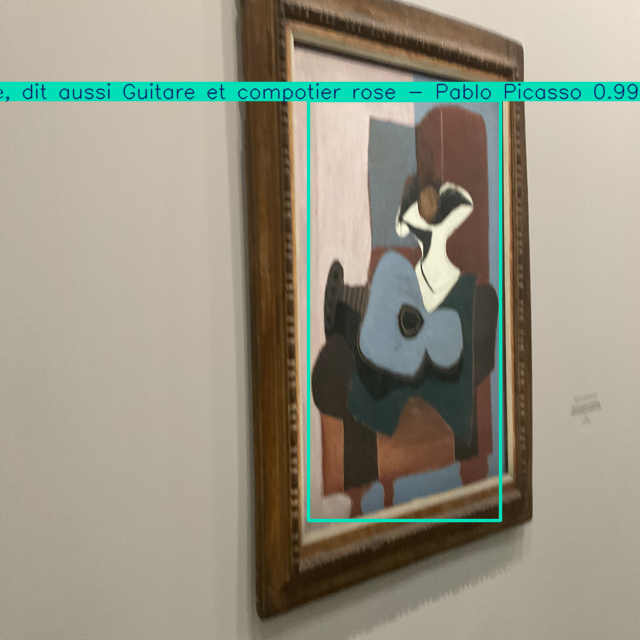

In [50]:
from PIL import Image

yolo = YOLO(path)
image_url = "/data/image_66.png"
run_yolo(yolo, image_url)  

In [34]:
model.export(format="coreml", int8=True, nms=True, imgsz=[640, 640], data="/data/data/data.yaml")

Ultralytics 8.3.36 🚀 Python-3.9.5 torch-2.5.1+cu124 CPU (AMD EPYC 7R13 Processor)

PyTorch: starting from 'working/runs/train36/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 95, 8400) (5.3 MB)


Torch version 2.5.1+cu124 has not been tested with coremltools. You may run into unexpected errors. Torch 2.4.0 is the most recent version that has been tested.
Failed to load _MLModelProxy: No module named 'coremltools.libcoremlpython'
Failed to load _MLModelAssetProxy: No module named 'coremltools.libcoremlpython'
Failed to load _MLModelProxy: No module named 'coremltools.libcoremlpython'
Failed to load _MLCPUComputeDeviceProxy: No module named 'coremltools.libcoremlpython'
Failed to load _MLGPUComputeDeviceProxy: No module named 'coremltools.libcoremlpython'
Failed to load _MLNeuralEngineComputeDeviceProxy: No module named 'coremltools.libcoremlpython'
Failed to load _MLModelProxy: No module named 'coremltools.libcoremlpython'
Failed to load _MLComputePlanProxy: No module named 'coremltools.libcoremlpython'



CoreML: starting export with coremltools 8.1...


Tuple detected at graph output. This will be flattened in the converted model.
Running compression pass palettize_weights: 100%|██████████| 176/176 [00:35<00:00,  4.97 ops/s]
Running MIL frontend_milinternal pipeline: 0 passes [00:00, ? passes/s]
Running MIL backend_mlprogram pipeline: 100%|██████████| 12/12 [00:00<00:00, 69.24 passes/s]


CoreML Pipeline: starting pipeline with coremltools 8.1...
CoreML Pipeline: pipeline success
CoreML: export success ✅ 74.2s, saved as 'working/runs/train36/weights/best.mlpackage' (2.8 MB)

Export complete (74.4s)
Results saved to /data/working/runs/train36/weights
Predict:         yolo predict task=detect model=working/runs/train36/weights/best.mlpackage imgsz=640 int8 
Validate:        yolo val task=detect model=working/runs/train36/weights/best.mlpackage imgsz=640 data=/data/data/data.yaml int8 
Visualize:       https://netron.app


'working/runs/train36/weights/best.mlpackage'

In [35]:
!cd working/runs/train17/weights/ && zip -r best_mlpackage.zip best.mlpackage && curl https://bashupload.com -T best_mlpackage.zip

updating: best.mlpackage/ (stored 0%)
updating: best.mlpackage/Data/ (stored 0%)
updating: best.mlpackage/Data/com.apple.CoreML/ (stored 0%)
updating: best.mlpackage/Data/com.apple.CoreML/model.mlmodel (deflated 90%)
updating: best.mlpackage/Data/com.apple.CoreML/weights/ (stored 0%)
updating: best.mlpackage/Data/com.apple.CoreML/weights/weight.bin (deflated 9%)
updating: best.mlpackage/Manifest.json (deflated 60%)


Uploaded 1 file, 52 244 540 bytes

wget https://bashupload.com/kc-6p/eHZ6Q.zip


